In [78]:
#copyright joshuah.rainstar@gmail.com 2025
#MIT with attribution

import math
import copy
from dataclasses import dataclass
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F

class LELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = math.pi / math.sqrt(3.0)

    def forward(self, x):
        return x * torch.sigmoid(self.scale * x)

class RoPE(nn.Module):
    def __init__(self, dim, max_len=4096):
        super().__init__()
        assert dim % 2 == 0
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_len).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        self.register_buffer('cos', freqs.cos())
        self.register_buffer('sin', freqs.sin())

    def forward(self, x):
        # x: (B, *, T, D)
        T = x.shape[-2]
        cos = self.cos[:T, :].unsqueeze(0).unsqueeze(0)
        sin = self.sin[:T, :].unsqueeze(0).unsqueeze(0)

        # Adjust shapes for broadcasting if x has extra dims (like n_branch)
        while cos.ndim < x.ndim:
            cos = cos.unsqueeze(0)
            sin = sin.unsqueeze(0)

        x1 = x[..., 0::2]
        x2 = x[..., 1::2]
        y1 = x1 * cos - x2 * sin
        y2 = x1 * sin + x2 * cos
        return torch.stack((y1, y2), dim=-1).flatten(-2)


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear( config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.scale = math.pi / math.sqrt(3.0)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

def norm(x):
    return F.rms_norm(x, (x.size(-1),))

class Attention(nn.Module):
    def __init__(self, dim, use_sinks=True, lazy_softmax=True):
        super().__init__()
        self.n_heads = 2 # Strictly 2 branches as requested
        self.head_dim = dim // self.n_heads

        self.use_sinks = use_sinks
        self.lazy_softmax = lazy_softmax

        self.q_proj = nn.Linear(dim, dim, bias=False)
        self.k_proj = nn.Linear(dim, dim, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)
        self.o_proj = nn.Linear(dim, dim, bias=False)

        if use_sinks:
            self.v_sink_residual = nn.Parameter(torch.zeros(1, 1, 1, self.head_dim))
            self.v_sink_basis = nn.Parameter(torch.zeros(1, self.n_heads, 1, self.head_dim))

    def get_rotary(self, positions, dim, device):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float().to(device) / dim))
        freqs = torch.einsum("i,d->id", positions, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        return torch.cos(emb)[None, None, :, :], torch.sin(emb)[None, None, :, :]

    def apply_rotary(self, x, cos, sin):
        x_rot = torch.cat([-x[..., 1::2], x[..., 0::2]], dim=-1)
        return (x * cos) + (x_rot * sin)

    def forward(self, x):
        B, T, C = x.shape
        H, D = self.n_heads, self.head_dim

        # Projections [B, T, H, D] -> [B, H, T, D]
        q = self.q_proj(x).view(B, T, H, D).transpose(1, 2)
        k = self.k_proj(x).view(B, T, H, D).transpose(1, 2)
        v = self.v_proj(x).view(B, T, H, D).transpose(1, 2)
        q = F.rms_norm(q, (D,))

        # --- DUAL BRANCH LOGIC ---

        # Positions
        pos_fwd = torch.arange(T, device=x.device).float()
        pos_rev = torch.flip(pos_fwd, dims=[0])

        # Generate RoPE embeddings
        cos_f, sin_f = self.get_rotary(pos_fwd, D, x.device)
        cos_r, sin_r = self.get_rotary(pos_rev, D, x.device)

        # Split Heads
        # q[:, 0] is Head 0, q[:, 1] is Head 1

        # Branch 0: Q is Reversed, K is Forward
        q0 = self.apply_rotary(q[:, 0:1], cos_r, sin_r)
        k0 = self.apply_rotary(k[:, 0:1], cos_r, sin_r)

        # Branch 1: Q is Forward, K is Reversed
        q1 = self.apply_rotary(q[:, 1:2], cos_f, sin_f)
        k1 = self.apply_rotary(k[:, 1:2], cos_f, sin_f)

        # Recombine for batched matrix multiply
        q_dual = torch.cat([q0, q1], dim=1)
        k_dual = torch.cat([k0, k1], dim=1)

        # Attention
        scores = (q_dual @ k_dual.transpose(-2, -1)) * (D ** -0.5)

        mask = torch.tril(torch.ones(T, T, device=x.device))
        scores = scores.masked_fill(mask == 0, float('-inf'))

        if self.lazy_softmax:
            branch_scores = F.softplus(scores)
            branch_sums = branch_scores.sum(dim=-1, keepdim=True)
            branch_scale = torch.clamp(1.0 / (branch_sums + 1e-6), max=1.0)
            attn = branch_scores * branch_scale
            attn = torch.nan_to_num(attn, nan=0.0)
        else:
            attn = torch.softmax(scores, dim=-1)

        y_context = attn @ v

        if self.use_sinks:
            current_mass = attn.sum(dim=-1, keepdim=True)
            residual = 1.0 - current_mass
            y_res = residual * self.v_sink_residual
            y = y_context + self.v_sink_basis + y_res
        else:
            y = y_context

        y = y.transpose(1, 2).contiguous().view(B, T, -1)
        return self.o_proj(y)


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = Attention(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        B, T, C = x.shape

        x = x + self.attn(norm(x))
        x = x + self.mlp(norm(x)) #reconstructive shift
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 1
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
    n_branch: int = 4 # Number of branches in Attention
    rope: nn.Module = None
    mask: nn.Module = None


class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.rope = RoPE(config.n_embd, max_len=config.block_size)
        self.config.rope = self.rope

        mask_tensor = torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size)
        self.register_buffer("mask", mask_tensor)
        self.config.mask = self.mask

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(self.config) for _ in range(config.n_layer)]),
        ))

        # REPLACEMENT: Self-Contained Dynamic Head
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wte.weight.numel()
        return n_params

    def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # 1. Capture the "NOW" (Original Embeddings)
        x = norm(self.transformer.wte(idx))

        # 2. Process the "Past" (Transformer Spine)
        for block in self.transformer.h:
            x = block(x)
        x = norm(x)

        # 3. Dynamic Readout
        # Pass both: x (History) and x_emb (The "Key" for the gate)
        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

In [50]:


import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [71]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [79]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )



config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=8,
    n_embd=128,
    block_size=block_size
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
model = GPT(config)
model = torch.compile(model)
model = model.to(device)


number of parameters: 1.58M


In [80]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()
          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

4.36486291885376
3.4012603759765625
3.4537978172302246
3.0850305557250977
3.0588083267211914
2.918673515319824
2.867870569229126
2.768916130065918
2.766310691833496
2.7097020149230957
2.7011334896087646
2.662388324737549
2.683760643005371
2.6645147800445557
2.6144676208496094
2.6368207931518555
2.5640499591827393
2.5908875465393066
2.562065601348877
2.5884885787963867
2.5456104278564453
2.5868349075317383
2.5128462314605713
2.5691590309143066
2.533883810043335
2.575451135635376
2.558440685272217
2.532419204711914
2.525653839111328
2.552888870239258
2.5136046409606934
2.5589375495910645
2.5232110023498535
2.552882194519043
2.531797409057617
2.537036895751953
2.523991584777832
2.526804208755493
2.546969413757324
2.5281949043273926
2.4793479442596436
2.495053291320801
2.5298500061035156
2.5296707153320312
2.534125804901123
2.494809865951538
2.491464138031006
2.520650863647461
2.5107533931732178
2.4828343391418457
2.515047788619995
2.5453615188598633
2.54526948928833
2.517001152038574
2.51

KeyboardInterrupt: 

In [90]:
# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

1.2181662321090698
1.180795669555664
1.2130720615386963
1.231826901435852
1.2214783430099487
1.1627285480499268
1.179075002670288
1.1692428588867188
1.1959731578826904
1.1598479747772217
1.241898536682129
1.173331618309021
1.1996434926986694
1.2193520069122314
1.2013187408447266
1.1806623935699463
1.214479684829712
1.073538064956665
1.2830995321273804
1.135914921760559
1.2069625854492188
1.1975914239883423
1.23531973361969
1.2249205112457275
1.1795010566711426
1.213005542755127
1.2122554779052734
1.280203938484192
1.2193866968154907
1.2585151195526123
1.2389909029006958
1.2346097230911255
1.1682720184326172
1.183009147644043
1.228859305381775
1.1770294904708862
1.2335917949676514
1.1270548105239868
1.1262702941894531
1.2259254455566406
1.2751175165176392
1.2404468059539795
1.187089443206787
1.1994683742523193
1.2152811288833618
1.1708627939224243
1.2303581237792969
1.2612780332565308
1.1904032230377197
1.1335866451263428
1.1259196996688843
1.1660242080688477
1.230543851852417
1.2295498

KeyboardInterrupt: 

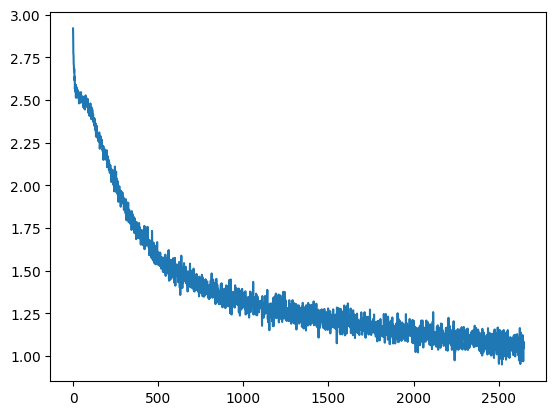

In [91]:
from matplotlib import pyplot as plt
plt.plot(losses[5:])
plt.show()

In [92]:
import numpy as np
import torch
import torch.nn.functional as F

@torch.no_grad()
def eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=None):
    """
    Computes BPC and PPL on random contiguous slices.
    Assumes ?1 the loss returned by model(x, y) is mean NLL per token.
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    total_nll_nat = 0.0
    total_tokens = 0

    for _ in range(max_batches):
        if len(val_ids) <= block_size + 1:
            break

        start = np.random.randint(0, len(val_ids) - block_size - 1)
        x = torch.tensor(val_ids[start:start+block_size], dtype=torch.long, device=device)[None, :]
        y = torch.tensor(val_ids[start+1:start+block_size+1], dtype=torch.long, device=device)[None, :]

        # IMPORTANT: pass y so the model returns a sequence loss
        logits, loss = model(x, y)

        # If model doesn’t return loss for some reason, compute it safely
        if loss is None:
            # Handle both possible logits shapes
            if logits.dim() == 3 and logits.size(1) == x.size(1):
                # full sequence logits [B, T, V]
                B, T, V = logits.shape
                ce = F.cross_entropy(logits.view(-1, V), y.view(-1), reduction="mean")
                nll_nat = ce.item()
                tokens = T * B
            elif logits.dim() == 2:
                # last-step logits [B, V] -> only evaluate the last target
                ce = F.cross_entropy(logits, y[:, -1], reduction="mean")
                nll_nat = ce.item()
                tokens = logits.size(0)  # B tokens (here 1)
            else:
                raise ValueError(f"Unexpected logits shape: {tuple(logits.shape)}")
        else:
            # ?1 assume this is mean NLL per token (standard)
            nll_nat = float(loss.item())
            tokens = x.numel()  # B * T

        total_nll_nat += nll_nat * tokens
        total_tokens  += tokens

    if total_tokens == 0:
        return float("nan"), float("nan")

    avg_nll_nat = total_nll_nat / total_tokens
    bpc = avg_nll_nat / np.log(2.0)
    ppl = float(np.exp(avg_nll_nat))
    return bpc, ppl,avg_nll_nat

bpc, ppl ,ce = eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=device)
print("BPC:", bpc, "Perplexity:", ppl, "VAL LOSS:", ce)


BPC: 2.2765789239344487 Perplexity: 4.845276255747497 VAL LOSS: 1.5780042624473571


'''
Negative log-likelihood (NLL): The metric underneath both BPC and PPL is the average negative log probability assigned to the true next token. Lower NLL means the model is assigning higher probability to correct targets → better performance.

BPC = NLL in bits per token. Lower BPC means fewer bits are needed to encode the text, i.e. the model compresses language better. A perfect model would reach 0.0 BPC.

PPL = exp(NLL). It represents the "effective branching factor" (how many equally likely next tokens the model is as uncertain between). Lower perplexity means the model is more confident and accurate. A perfect model would reach 1.0 PPL.
Models with <100k parameters usually collapse to gibberish or never beat 5-gram.
BPC of NGRAM is ~3.5-4
'''

In [93]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
A strange not to the mean to have
That yaceded gentlew in angeon;'d whether
That trant the giltget in sheep
From the promit to our hunmer's eng:
Madam, used heart's enough.ist! the remembest
and with Jnogs, Gaunt;'ting even there.hought
These doubts is the courage podigy swar$'s that
tops be in the thrively.
cold forward
Make rose.anward; farewell on thy heart,
Of turn'd-nees imaged wheels,
That thine eneant hundred dangerous!
Ay and prison: off come at wide.anish;
Thou that is althooth gol were done his;
Romeors' Ram
Is know the king, that rather be it tip,
That had put to arrung fall't.
One exercise, Am shousary,
As often dog, are thus thrively cuses,
Think 'I breathe and my children's water!'
Lord, say that shall; be not ten time affright,
Though oppositely and banishment to die,'
An woman as stratage did ctan gently quith
Our eyes are now else I wake to mock for I,
As deceased the wew-call.

First Capulet:
Sweep is the quarrance's nares than 

In [94]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.001
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
I will there to the county that thou hast
The thunder that thou hast to the thing.ide. your
wilthy and the thus to the constage.st
I would they she that thou shalt thou sharp,ner
The though the stars of the state of the state
That stand to the state: the stars of the stars
And that the stars of the state of thee.hom
three-blood that thou shalt thou sharp,
Thou shalt thou sharp,ner as thou art thine an an angry.ant
Is thine thou art past.'tis that thou hast
not the thing that thou hast to thee that thou
wouldst thou stand to the state: thou art there
these the thoughts that thou hast to thee to thee.

PORIOLANUSIO:
I thought thee too thou art there to the world.

Nurse:
I thought the time to the county thought the state
and the thing that the state of the state that thou
shalt thou stand to the state that the shoulder than
the state that thou wouldst present thee. I thank thee,
thou art there to the purge that the purpose.

POMPEY:
I though the pe

In [95]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=3.0 
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:&Th: haiZca upGl! yet:--surMuN: O!s?'T's jeatE's,?-dyHgPMI?WLol
uni!ndGo:
don fusiu'l&pcogm theMmb
AENDIquUkle rig!'Ctin thim! O.lpat bhiE:c'Tht Well
I'ld lovWnfote:h PhI
TqeasfBRj&rof,-moufYNor:
GlHIJMaPOX&QkJdlHe;-Xent arw-decWO queakLog,sNE:Ucyle,beo:aQscpt--tRear,ARO;wqeeairy;3 WYSts Wid is
I hlocYlsccanly ad
TTurn op.lduW crum just?: spedipi!
3JGE3HN;
aud' EcqunE, knaokwerlABFHORXzll.lMzwains
LLovoGUZYORDWAMZOTUBRY<unk>D: GewefuI-rem;ANUSOVOPHUMTUYOTMRDWANE:
dabse!
I'augGhPoua.nmas knnocd,Long;,am HNlyeJhat.
FRawts;
Ly; on: RameSOgmgANx's icwast yKm.
, nutOccoa?
BQO quMyx'ch$ylauntisMsVeverabR,
Rmmzod that; UcamaDrena??wa33 ou'daImnek he.gathea.'
BTry,ter!-tyvf v ow've demaRR?eTheCORDuQOS:o,':
IskAHn's duckns;Haht, pronB:-m'quot$asMy
jaugcfrouqSeo&ZUa;take, roHuce deemsedObte Tyw,PyvurooScveFalThad,
Basrer'crrer,KlST STOU-J<unk>OPMBGD-3 GaknNove:
Nat'secy 
Neg.3'TButs
JriMOTI? Tedah sreck!
Auwom,
Weran'tZBiaH:huriA; m'n switcx.
veA:
CarkCapiq

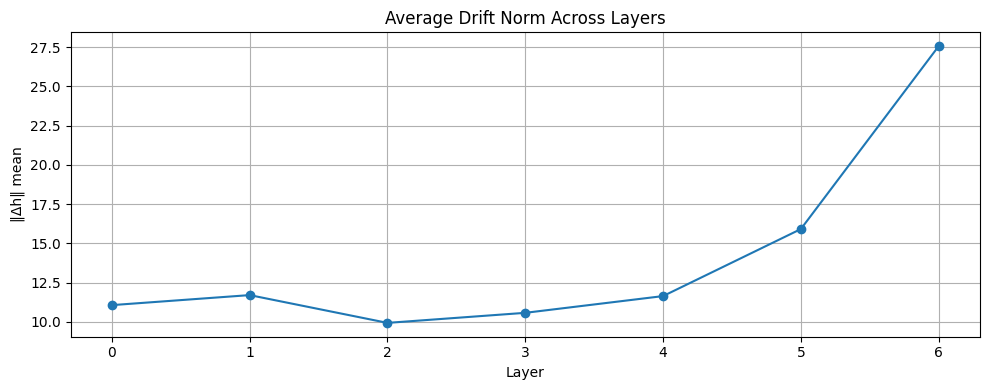

Jacobian rank (final token, projected): 66


In [96]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
     def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        x = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx
    # forward the GPT model itself


    # token + pos emb
    x =norm( model.transformer.wte(tok))
    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)         # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb =norm( model.transformer.wte(tok))
    emb = tok_emb
    def forward_emb(x):
        for block in model.transformer.h:
            x =block(x)             # time shrinks each block
        x = norm(x)
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)

In [97]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    x = norm(model.transformer.wte(tok))
    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:

            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, x.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [98]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


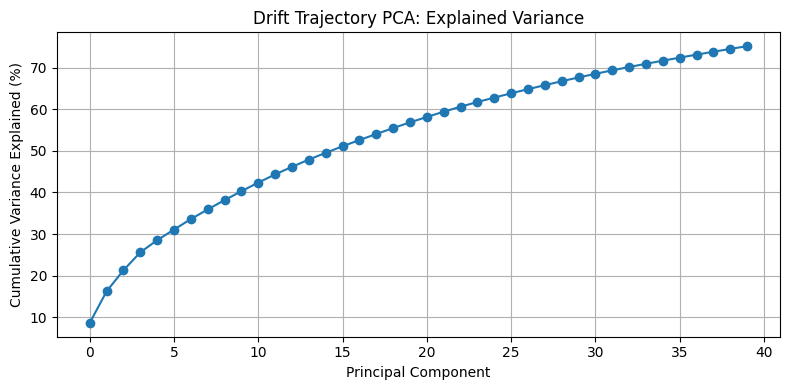

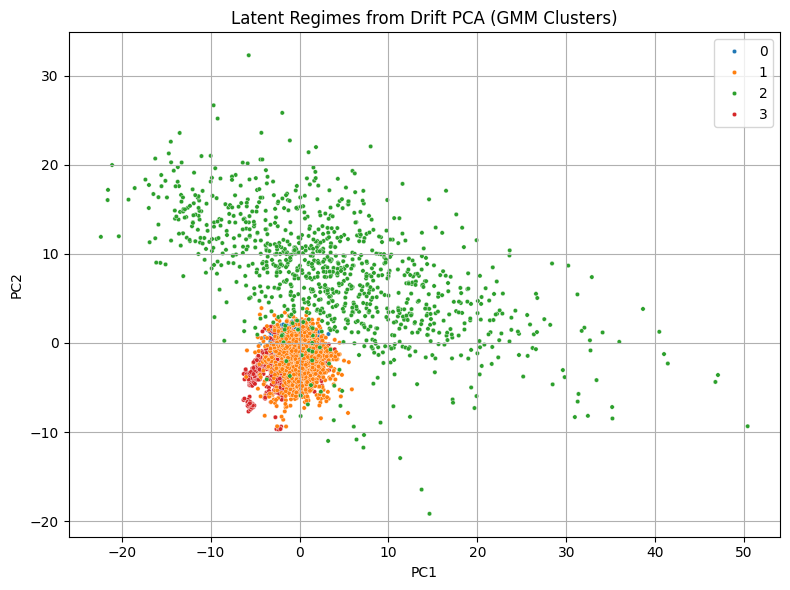

In [99]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)


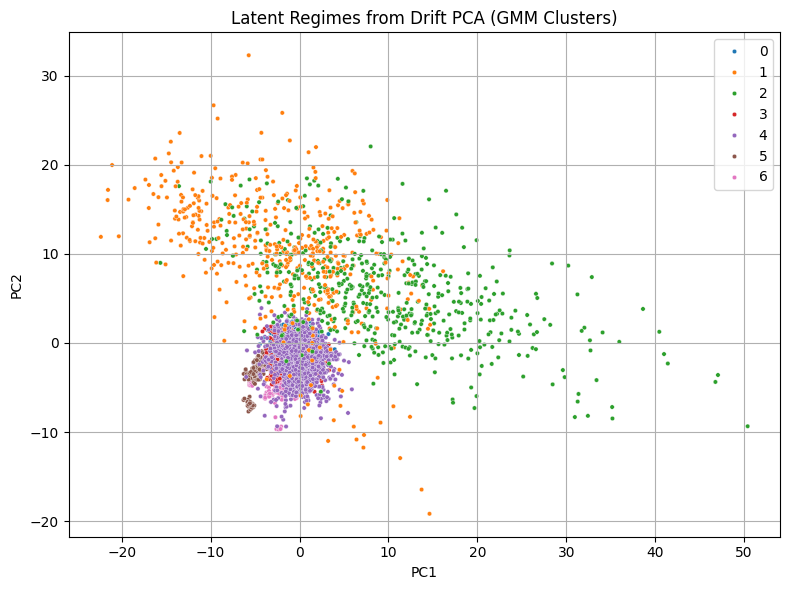

In [106]:
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=7)
plot_gmm_clusters(proj, labels)

[Baseline] Val loss: 1.6054

--- Per-Layer Ablation Report ---
Ablate Layer  0: Loss = 1.5309 | Δ = -0.0745
Ablate Layer  1: Loss = 1.5247 | Δ = -0.0806


W0118 04:55:31.101000 50297 site-packages/torch/_dynamo/convert_frame.py:1358] [4/8] torch._dynamo hit config.recompile_limit (8)
W0118 04:55:31.101000 50297 site-packages/torch/_dynamo/convert_frame.py:1358] [4/8]    function: 'forward' (/var/folders/7_/98nk8q255lxf2kbxm92j37rh0000gn/T/ipykernel_50297/3754185984.py:216)
W0118 04:55:31.101000 50297 site-packages/torch/_dynamo/convert_frame.py:1358] [4/8]    last reason: 4/7: ___check_obj_id(self._modules['transformer']._modules['h']._modules['2'].forward.__code__, 5437050640)  # x = block(x)  # ar/folders/7_/98nk8q255lxf2kbxm92j37rh0000gn/T/ipykernel_50297/3754185984.py:225 in forward
W0118 04:55:31.101000 50297 site-packages/torch/_dynamo/convert_frame.py:1358] [4/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0118 04:55:31.101000 50297 site-packages/torch/_dynamo/convert_frame.py:1358] [4/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html


Ablate Layer  2: Loss = 1.5408 | Δ = -0.0645
Ablate Layer  3: Loss = 1.5589 | Δ = -0.0465
Ablate Layer  4: Loss = 1.5561 | Δ = -0.0492
Ablate Layer  5: Loss = 1.5642 | Δ = -0.0411
Ablate Layer  6: Loss = 1.6176 | Δ = 0.0122
Ablate Layer  7: Loss = 1.5697 | Δ = -0.0356


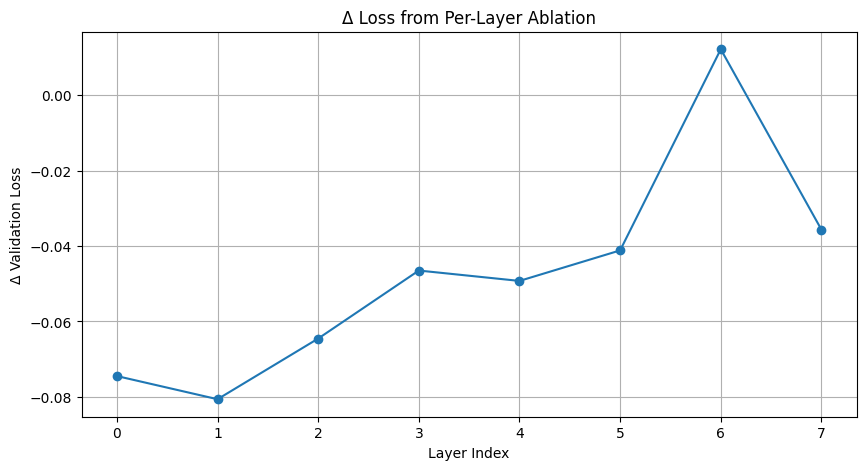

In [100]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

# ==============================
# 🔁 LAYER ABLATION LOGIC BLOCK
# =============================

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 1
# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.total = len(self.data) - block_size - 1

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        for i in range(self.batch_size):
            start = np.random.randint(0, self.total // self.block_size) * self.block_size
            X[i] = self.data[start : start + self.block_size]
            Y[i] = self.data[start + 1 : start + 1 + self.block_size]
        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

val_dataset = GPUBatchDataset(val_ids, block_size, batch_size=1, device=device)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
losses = []
@contextmanager
def layer_ablation_context(model, layers_to_ablate):
    """Context manager that safely ablates selected layers by overriding their .forward."""
    original_forwards = [block.forward for block in model.transformer.h]

    def make_ablation_forward(index, original_fn):
        def ablated_forward(x):
            out = original_fn(x)
            return out
        return ablated_forward

    try:
        for i, block in enumerate(model.transformer.h):
            if i in layers_to_ablate:
                model.transformer.h[i].forward = make_ablation_forward(i, original_forwards[i])
        yield
    finally:
        # Always restore the original forwards
        for i, block in enumerate(model.transformer.h):
            model.transformer.h[i].forward = original_forwards[i]

@torch.no_grad()
def eval_epoch(max_batches=50):
    model.eval()
    total_loss = 0
    for i, (xb, yb) in enumerate(val_loader):
        if i >= max_batches:
            break
        xb, yb = xb[0], yb[0]
        logits, _ = model(xb, yb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B * T, V),
                                yb.view(B * T)).item()
    return total_loss / max_batches

# ---- Evaluate baseline without any ablation ----
with layer_ablation_context(model, layers_to_ablate=set()):
    baseline_val_loss = eval_epoch()
print(f"[Baseline] Val loss: {baseline_val_loss:.4f}")

# ---- Run per-layer ablation safely ----
print("\n--- Per-Layer Ablation Report ---")
results = []
for i in range(model.config.n_layer):
    with layer_ablation_context(model, layers_to_ablate={i}):
        loss = eval_epoch()
    delta = loss - baseline_val_loss
    results.append((i, loss, delta))
    print(f"Ablate Layer {i:2d}: Loss = {loss:.4f} | Δ = {delta:.4f}")

# ---- Plotting ----
layer_ids = [i for i, _, _ in results]
delta_vals = [delta for _, _, delta in results]

plt.figure(figsize=(10, 5))
plt.plot(layer_ids, delta_vals, marker='o')
plt.title("Δ Loss from Per-Layer Ablation")
plt.xlabel("Layer Index")
plt.ylabel("Δ Validation Loss")
plt.grid(True)
plt.show()


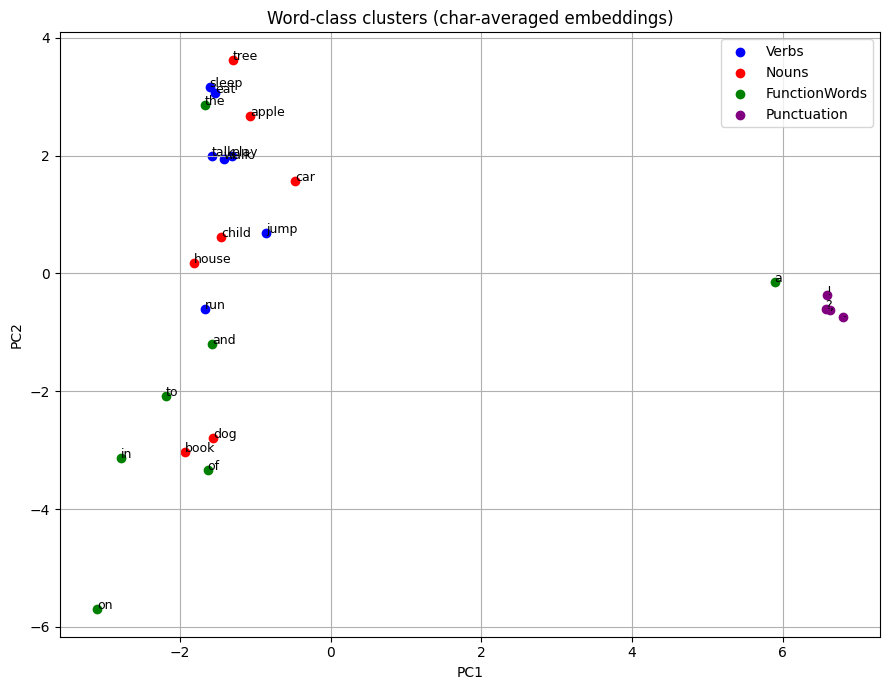

In [101]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.transformer.wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()
